# CISA KVE EPSS Data Analyis 

In [1]:
import pandas as pd
import json
import requests
import os
import glob
import numpy as np

In [2]:
cisa_df = pd.read_csv("https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv")
cisa_df = cisa_df
cisa_df.columns = cisa_df.columns.str.strip("\u200b")
cisa_df = cisa_df.rename(columns={"cveID": "CVE", "shortDescription" : "Description", "dateAdded" : "Date"})

In [3]:
epss = pd.read_csv('epss_scores-current.csv', skiprows=1)
epss = epss.rename(columns={"cve": "CVE", "epss" : "EPSS", "percentile" : "EPSS Percentile"})

In [4]:
row_accumulator = []
for filename in glob.glob('nvdcve-1.1-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['CVE_Items']:
            cve = entry['cve']['CVE_data_meta']['ID']
            try:
                base_score = entry['impact']['baseMetricV3']['cvssV3']['baseScore']
            except KeyError:
                base_score = '0.0'
            new_row = { 
                'CVE': cve, 
                'CVSS3': base_score,
            }
            row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)
        
nvd['CVSS3'] = pd.to_numeric(nvd['CVSS3']);
nvd['CVSS3'] = nvd['CVSS3'].replace(0, np.nan);       

In [5]:
epss_kev = pd.merge(cisa_df, epss, left_on='CVE', right_on='CVE')
epss_kev_nvd =  pd.merge(epss_kev, nvd, left_on='CVE', right_on='CVE')
epss_kev_nvd =  epss_kev_nvd[["CVE", "CVSS3", "EPSS", "EPSS Percentile", "Description", "Date"]]

## CISA KEV Score Scatter Plot

/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1351: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


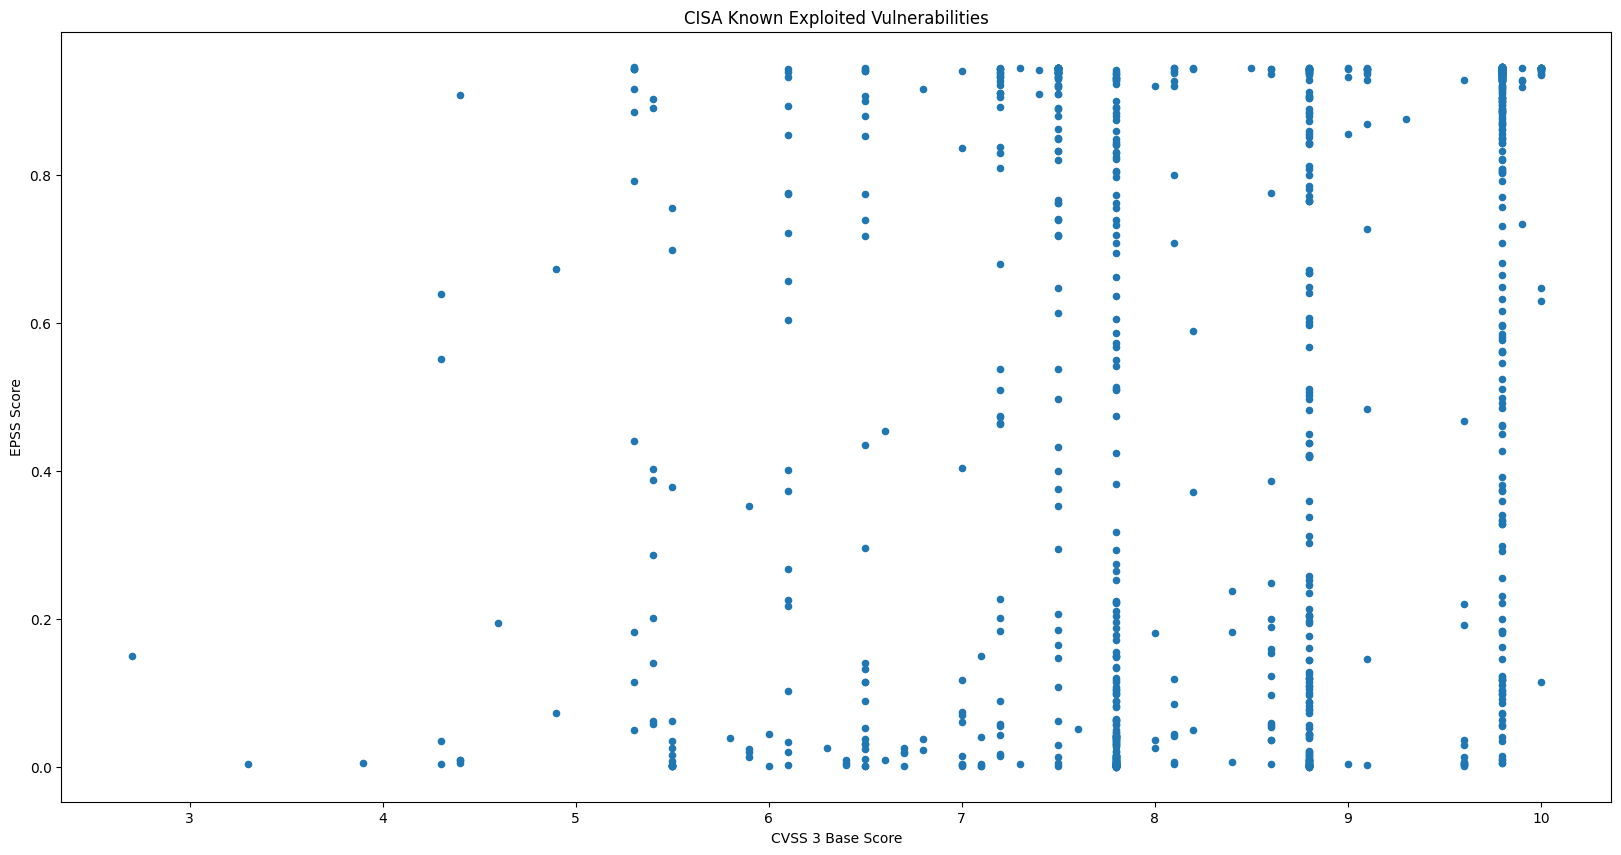

In [6]:
ax = epss_kev_nvd.plot.scatter(x='CVSS3',
                     y='EPSS',
                     colormap='jet',
                     figsize=(20, 10),
                     title='CISA Known Exploited Vulnerabilities');
ax.set_xlabel("CVSS 3 Base Score");
ax.set_ylabel("EPSS Score");
ax.figure.savefig('epss_kev_nvd.png');

## Export to CSV

In [7]:
epss_kev_nvd.to_csv("epss_kev_nvd.csv", index=False)
epss_kev_nvd.head(10)

,CVE,CVSS3,EPSS,EPSS Percentile,Description,Date
0,CVE-2025-5777,7.5,0.49701,0.97681,Citrix NetScaler ADC and Gateway contain an ou...,2025-07-10
1,CVE-2019-9621,7.5,0.91778,0.99663,Synacor Zimbra Collaboration Suite (ZCS) conta...,2025-07-07
2,CVE-2019-5418,7.5,0.94336,0.99944,Rails Ruby on Rails contains a path traversal ...,2025-07-07
3,CVE-2025-6554,NaN,0.05303,0.89568,Google Chromium V8 contains a type confusion v...,2025-07-02
4,CVE-2025-48928,NaN,0.09865,0.92620,TeleMessage TM SGNL contains an exposure of co...,2025-07-01
5,CVE-2025-48927,NaN,0.09980,0.92675,TeleMessage TM SGNL contains an initialization...,2025-07-01
6,CVE-2025-6543,9.8,0.16125,0.94501,Citrix NetScaler ADC and Gateway contain a buf...,2025-06-30
7,CVE-2019-6693,6.5,0.73903,0.98748,Fortinet FortiOS contains a use of hard-coded ...,2025-06-25
8,CVE-2024-0769,9.8,0.75654,0.98835,D-Link DIR-859 routers contain a path traversa...,2025-06-25
9,CVE-2024-54085,9.8,0.10334,0.92829,AMI MegaRAC SPx contains an authentication byp...,2025-06-25
